---

# Fine tuning de transformers

En las siguientes celdas, nos encargaremos de re-entrenar las últimas capas de un modelo Vision Transformer, preentrenado por huggingface, mediante la plataforma weights and biases. Para ello, instanciaremos un modelo pre-entrenado de google, adaptaremos nuestro dataset a las preferencias del modelo, y entrenaremos el transformer por 3 epochs.

In [1]:
from typing import List, Dict, Tuple, Any
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from transformers import ViTFeatureExtractor
from transformers import ViTFeatureExtractor, ViTForImageClassification
from transformers import TrainingArguments, Trainer
from keras.backend import clear_session

In [2]:
# Load the dataset from dataset.npz
dataset_dir = '/kaggle/input/spam10000'
dataset_path = os.path.join(dataset_dir, 'dataset.npz')
print('Loading dataset...')
data = np.load(dataset_path)
images = data['images']
labels = data['labels']
del data

# Reshape images to 128x128x3
print('Reshaping images...')
images = np.array([
        cv2.resize(image, (224, 224)) for image in images
    ])
print('Dataset loaded')

Loading dataset...
Reshaping images...
Dataset loaded


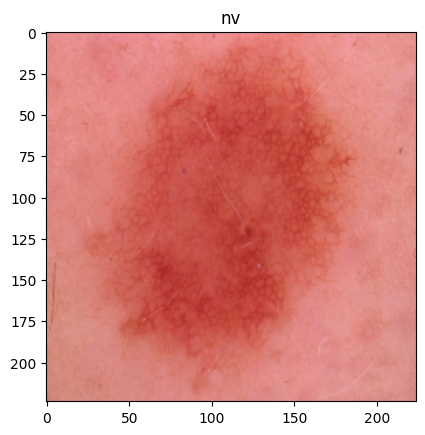

In [3]:
plt.imshow(images[10])
plt.title(labels[10])
plt.show()

### Adaptación del dataset

In [4]:
class MedicalImageDataset(Dataset):
    def __init__(self, images, labels, feature_extractor):
        self.images = images
        self.labels = labels
        self.feature_extractor = feature_extractor
        self.label_to_int = {label: idx for idx, label in enumerate(set(labels))}
        self.int_to_label = {idx: label for label, idx in self.label_to_int.items()}
        self.encoded_labels = [self.label_to_int[label] for label in labels]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.encoded_labels[idx]
        processed_image = self.feature_extractor(image, return_tensors="pt")["pixel_values"][0]
        return {"pixel_values": processed_image, "labels": torch.tensor(label, dtype=torch.long)}


In [5]:
# Split dataset
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Load feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

# Create datasets
train_dataset = MedicalImageDataset(train_images, train_labels, feature_extractor)
val_dataset = MedicalImageDataset(val_images, val_labels, feature_extractor)


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [6]:
from transformers import Trainer, TrainingArguments, ViTForImageClassification

# Load model
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=len(set(labels)),
    ignore_mismatched_sizes=True
)

# Set training parameters
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2
)

# Define accuracy metric
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy = (predictions == labels).mean()
    return {"accuracy": accuracy}attachment:b13700c6-c807-4599-a4b5-f8edd917420a.png

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### Entrenamiento del transformer en plataforma externa

La siguiente celda se ejecutó en la plataforma `wandb`, y se puede acceder a los logs de sus resultados en los enlaces que se encuentran aquí debajo

In [7]:
# Instantiate trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,0.317500,0.435239,0.847728
2,0.221100,0.401813,0.878183
3,0.097500,0.448209,0.886171


TrainOutput(global_step=3006, training_loss=0.3055012629665459, metrics={'train_runtime': 26722.6696, 'train_samples_per_second': 0.899, 'train_steps_per_second': 0.112, 'total_flos': 1.862680931735888e+18, 'train_loss': 0.3055012629665459, 'epoch': 3.0})

### Resultado final: Validation Accuracy de 0.886171
Tiempo total de entrenamiento: 7 horas 23 minutos 55 segundos

## Resultados en entrenamiento
![image.png](vit_results_train.png)
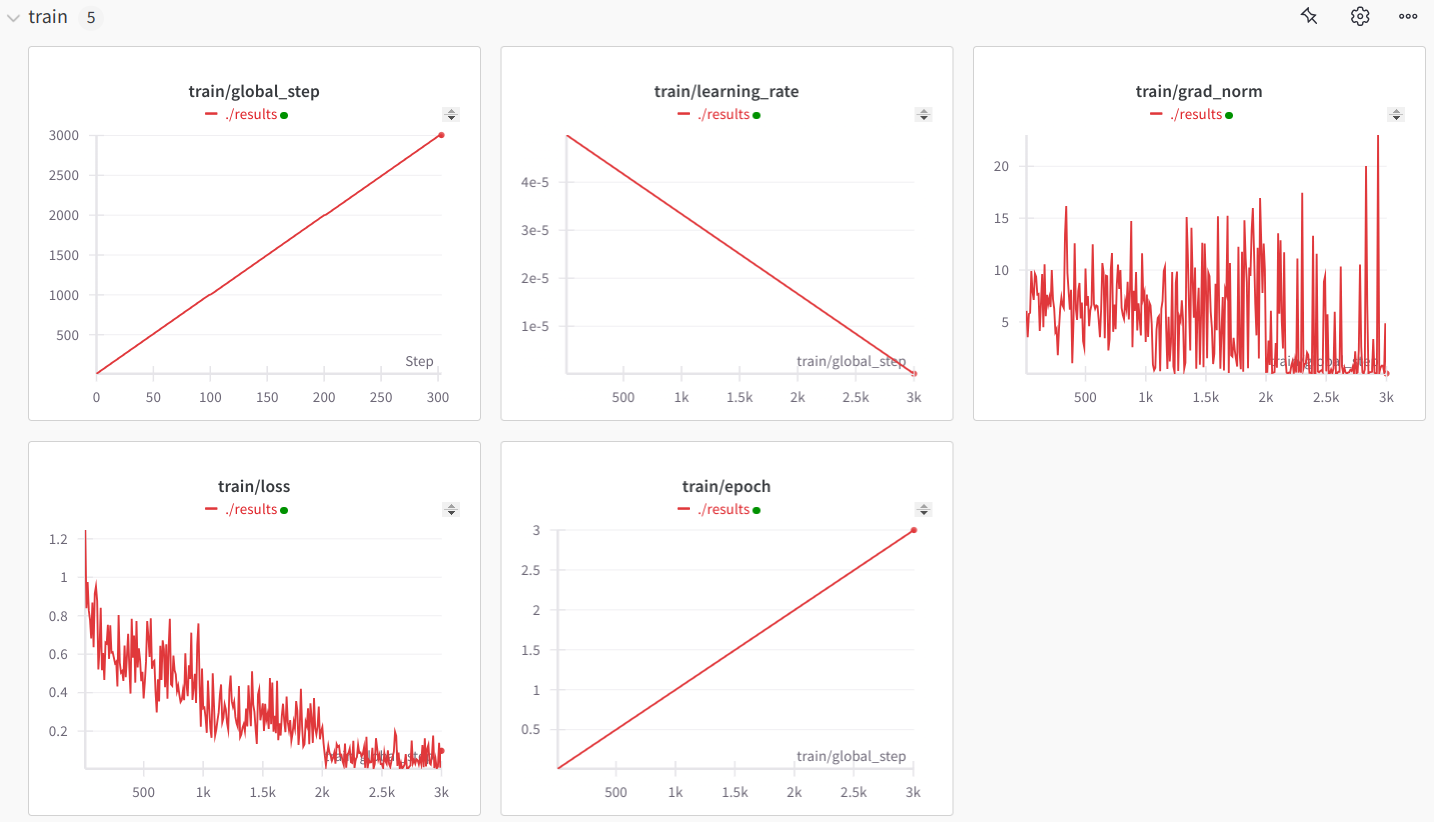

## Resultados en validación
![vit_results_val.png](vit_results_val.png)
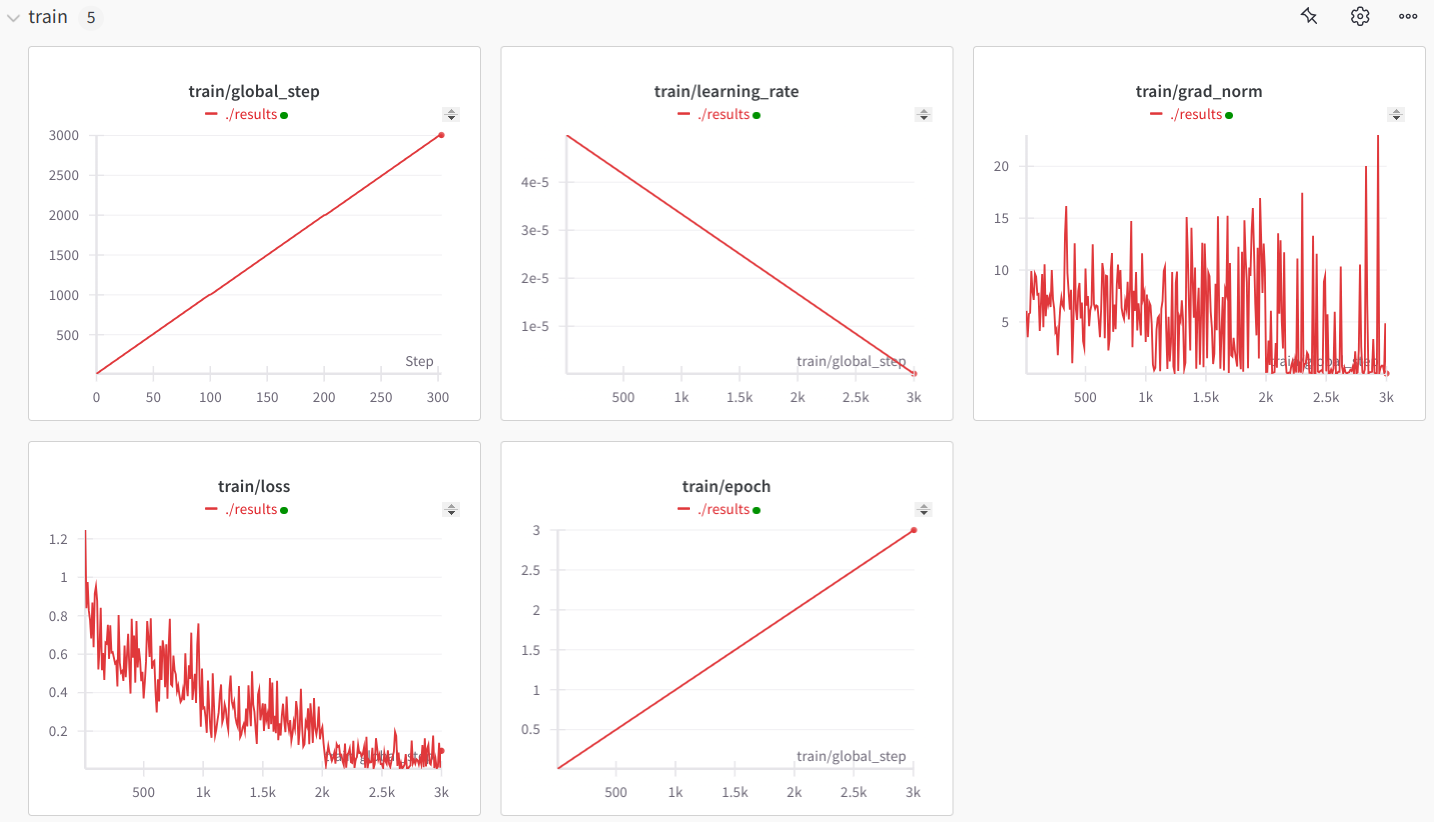
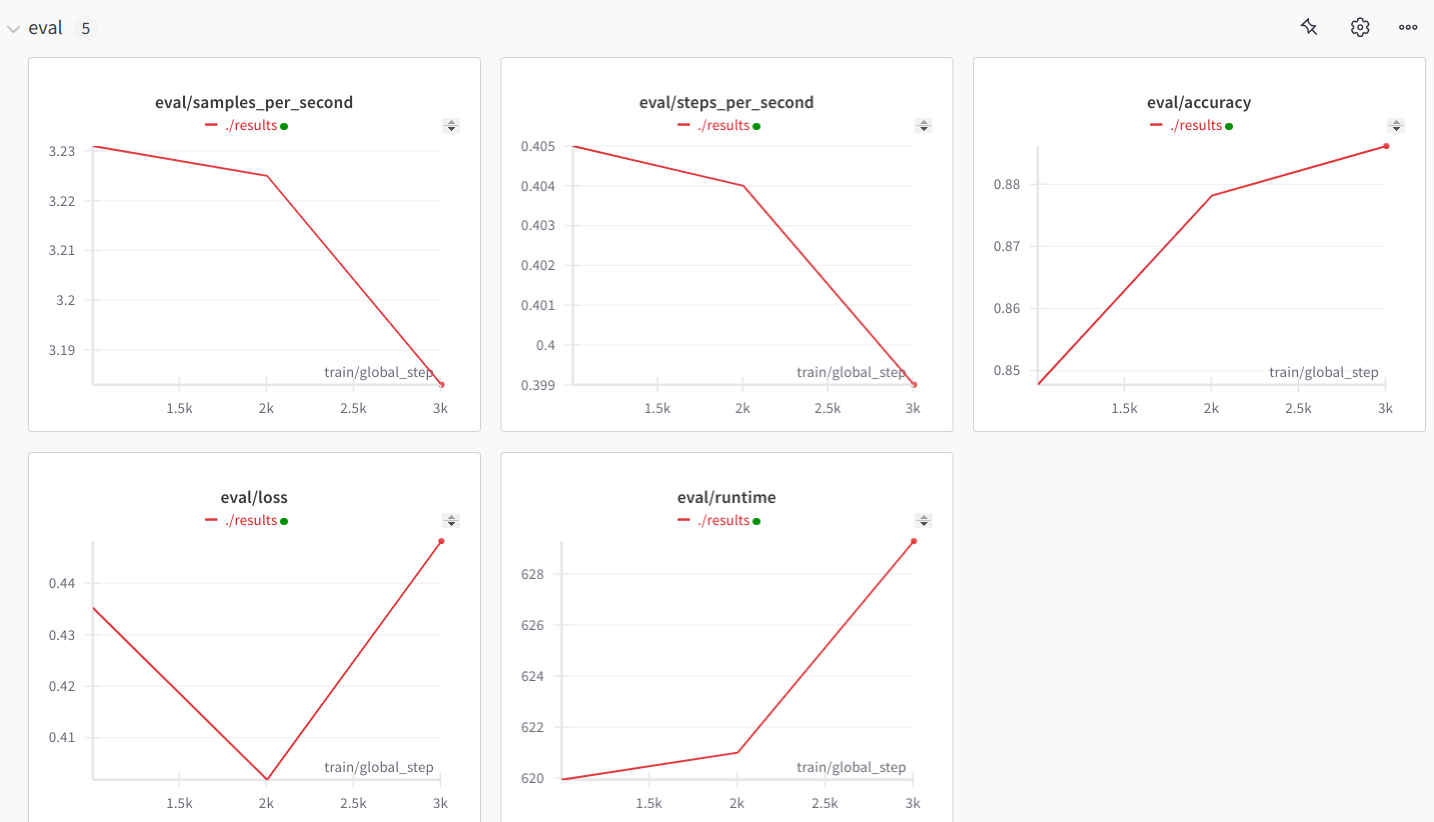

## Conclusiones sobre el fine tuning de transformers

En tan solo una epoch, se obtuvo una accuracy mayor al 84% en validation, incluso con un dataset fuertemente desbalanceado. Esto demuestra la enorme capacidad de las arquitecturas transformadoras a la hora de comprender significado semántico. No obstante, se tardó al rededor de 2 horas y media para entrenar cada epoch, por lo que un ajuste más fino requeriría de una cantidad descomunal de tiempo de ejecución, y un gran gasto computacional.